In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pybloom import BloomFilter
import scipy.interpolate as interp
import scipy.optimize
from scipy import fftpack
import scipy.signal
import scipy.io.wavfile

# Simulation and Numerical Methods: Labs
## Author Solutions

### 1. Monte Carlo Integration
One of the most classical examples of a Monte Carlo algorithm is numerical integration. It's very useful if we want to approximate a definite integral even if it doesn't have an analytical solution. It's also quite fast and precise.

We'll calculate the integral
$$ \int_0^\pi \sin(x^2)dx $$

We have to use a bounding box. We can either plot the function and select a bounding box, or try to think about one. In this case, $-1 \le \sin(\alpha) \le 1$, so we can take the rectangle ${(x, y): 0 \le x \le \pi, -1 \le y \le 1}$ as our bounding box. After that, we'll generate many random points inside that box. The proportion of points "under" the curve to all points will give us an approximation to the integral.

In [2]:
def squared_sine(x):
    return math.sin(x ** 2)

def integrate(f, x_min, x_max, y_min, y_max, points):
    inside_points = 0
    for i in range(points + 1):
        for j in range(points + 1):
            x = np.random.uniform(x_min, x_max)
            y = np.random.uniform(y_min, y_max)
            # Points within the area
            if math.fabs(y) <= math.fabs(f(x)):
                if f(x) > 0 and y > 0 and y <= f(x):
                    inside_points += 1
                # Points under the x-axis have to be subtracted from the total area
                if f(x) < 0 and y < 0 and y >= f(x):
                    inside_points -= 1
    rect_area = (x_max - x_min) * (y_max - y_min)
    return inside_points / (points ** 2) * rect_area

print(integrate(squared_sine, 0, math.pi, -1, 1, 1000))

0.7748549784520009


In [3]:
# Vectorized version (faster)
def squared_sine_v(x):
    return np.sin(x ** 2)

def integrate_v(f, x_min, x_max, y_min, y_max, points):
    x = np.random.uniform(x_min, x_max, size = points ** 2)
    y = np.random.uniform(y_min, y_max, size = points ** 2)
    y_hat = f(x)
    pos_area = (np.abs(y) <= np.abs(y_hat)) & (
        y_hat > 0) & (y > 0) & (y <= y_hat)
    neg_area = (np.abs(y) <= np.abs(y_hat)) & (
        y_hat < 0) & (y < 0) & (y >= y_hat)
    rect_area = (x_max - x_min) * (y_max - y_min)
    return rect_area * (len(y[pos_area]) - len(y[neg_area])) / (points ** 2)
    
print(integrate_v(squared_sine_v, 0, math.pi, -1, 1, 1000))

0.774226659921283


### 2. Estimating $\pi$
Now we're going to perform the same Monte Carlo simulation to estimate the value of $\pi$. In this case, we'll be calculating the area of a circle centered at the origin with radius 1 (which is equal to $\pi.1^2 = \pi$). Due to symmetry, we can calculate only values in the first quadrant of the coordinate system and multiply by 4. This will make the result more precise (1/4 of the original points will be needed to achieve the same precision).

The circle is given by $x^2 + y^2 <= 1$ and the bounding box is ${(x, y): 0 \le x, y \le 1}$. We'll also plot the relevant points to see what we're doing.

3.1562


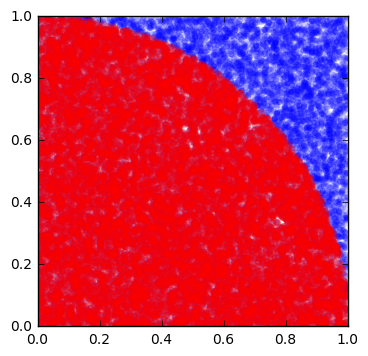

In [4]:
points = 20000
x = np.random.uniform(0, 1, points)
y = np.random.uniform(0, 1, points)
inside_circle = x ** 2 + y ** 2 <= 1
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axes().set_aspect("equal", "box")
plt.scatter(x, y, alpha = 0.2, edgecolor = "none")
plt.scatter(x[inside_circle], y[inside_circle],    color = "red", alpha = 0.2)
print(len(y[inside_circle]) / points * 4)

### 3. Profit Simulation
We have to simulate the profit of a grocery shop with fixed prices (see the code for price information).

The number of customers follows a Gaussian distribution with mean 500 and standard deviation 20. Each customer buys exactly one article. Each article has a price and popularity (probability of buying).

We can estimate the following quantities:
* Profit per customer = price * probability
* Profit = customers * profit per customer

We're going to simulate the profit for 1000 days.

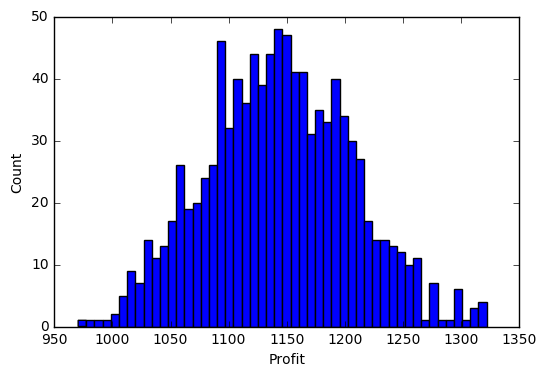

In [5]:
def get_customer_profit():
    n = np.random.random()
    if n <= 0.5:
        return 0.99
    elif n <= 0.65:
        return 2.89
    elif n <= 0.85:
        return 2
    else:
        return 6.39

days = 1000
profits = []    
for day in range(days):
    customers = np.floor(np.random.normal(500, 20))
    profit = 0
    for customer in np.arange(customers):
        profit += get_customer_profit()
    profits.append(profit)
plt.hist(profits, bins = 50)
plt.xlabel("Profit")
plt.ylabel("Count")
plt.show()

Now we want to simulate a different case. Each customer can pick one, two or three items with probabilities 0.5, 0.3 and 0.2 respectively. The picked items are independent (a customer can buy two or three items of the same article). We want to see how this changes the distribution and compare the two distributions.

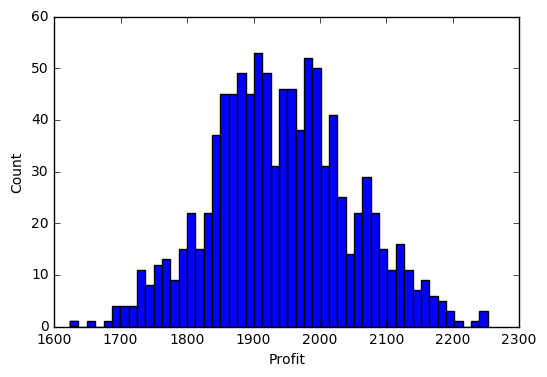

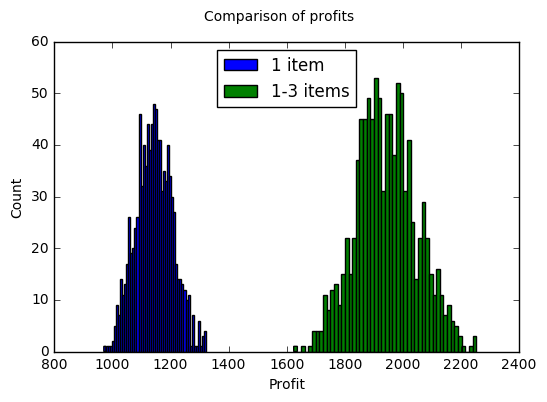

In [6]:
def get_total_customer_profit():
    n = np.random.random()
    if n <= 0.5:
        return get_customer_profit(1)
    elif n <= 0.8:
        return get_customer_profit(2)
    else:
        return get_customer_profit(3)
def get_customer_profit(items = 1):
    sum = 0
    for i in range(items):
        n = np.random.random()
        if n <= 0.5:
            sum += 0.99
        elif n <= 0.65:
            sum += 2.89
        elif n <= 0.85:
            sum += 2
        else:
            sum += 6.39
    return sum

days = 1000
new_profits = []    
for day in range(days):
    customers = np.floor(np.random.normal(500, 20))
    profit = 0
    for customer in np.arange(customers):
        profit += get_total_customer_profit()
    new_profits.append(profit)
plt.hist(new_profits, bins = 50)
plt.xlabel("Profit")
plt.ylabel("Count")
plt.show()

plt.suptitle("Comparison of profits")
plt.hist(profits, bins = 50, label = "1 item")
plt.hist(new_profits, bins = 50, label = "1-3 items")
plt.xlabel("Profit")
plt.ylabel("Count")
plt.legend(loc = 0)
plt.show()

We can see that the distributions differ a lot: when we have between one and three items we have a much larger expected profit, and also - more variability. Other than that, the two distributions seem quite similar, and they are both a little negatively skewed (more mass goes to the lower numbers).

### 4. Using a Bloom Filter
We're going to use a Bloom filter for spellchecking. We're going to read the unix list of words from an URL, then seed them inside a Bloom filter. After that we'll create a function which, given a list of words, returns those which are misspelled.

In [7]:
url = "https://raw.githubusercontent.com/eneko/data-repository/master/data/words.txt"
words = pd.read_table(url, header = None)[0].str.lower().tolist()

spell_checker = BloomFilter(capacity = len(words), error_rate = 0.0005)
results = [spell_checker.add(w) for w in words]

In [8]:
def check_spelling(words):
    return [w for w in words if not (w.lower() in spell_checker)]

print(check_spelling(["Hello", "there"]))
print(check_spelling(["Howare", "you"]))
print(check_spelling("The quick brown fox jumps over the lazy dog".split(" ")))

[]
['Howare']
['jumps']


Note that this simple spell checker does not recognize words coming from the same root. In this case we can use "stemming" - an algorithm to extract the stems of all words. We can populate the spell checker with all stems. After that, when checking words, we can also perform stemming and compare all stems, not all original words. This will take care of prefixes and suffixes.

### 5. Interpolation
We'll check how `scipy` will interpolate a list of given values using several interpolation functions.

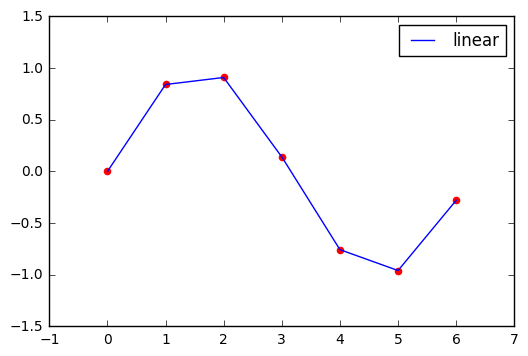

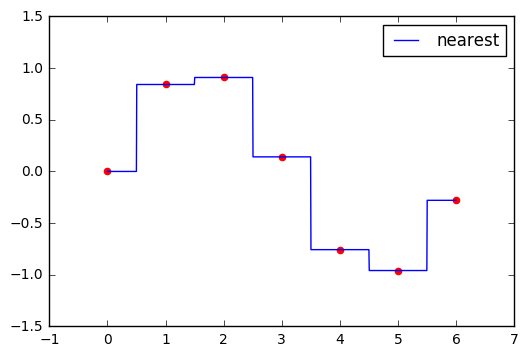

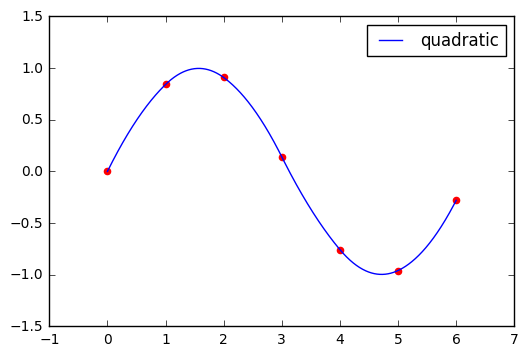

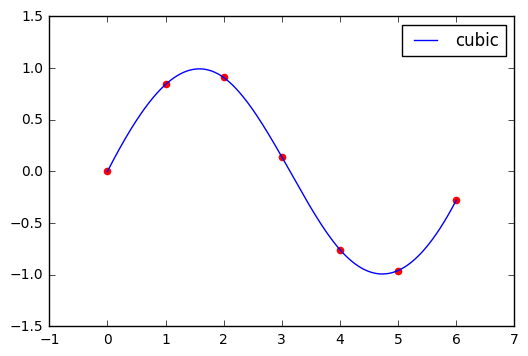

In [9]:
x = np.array(np.arange(0, 7))
y = np.array([0, 0.8415, 0.9093, 0.1411, -0.7568, -0.9589, -0.2794])
for kind in ["linear", "nearest", "quadratic", "cubic"]:
    f = interp.interp1d(x, y, kind = kind)
    plt.scatter(x, y, color = "red")
    x_hat = np.linspace(0, 6, 1000)
    plt.plot(x_hat, f(x_hat), label = kind)
    plt.legend()
    plt.show()

### 6. Polynomial Interpolation
We're going to explore polynomial interpolation of different degrees. We'll also see that extrapolation can give wildly different results depending on the values and the target function.

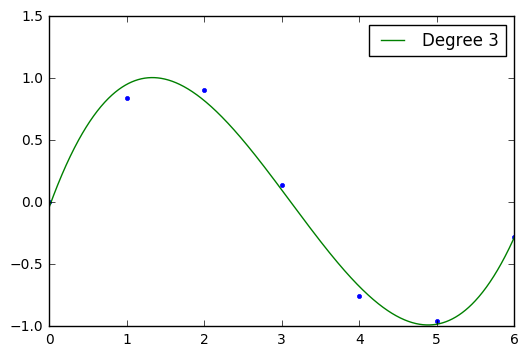

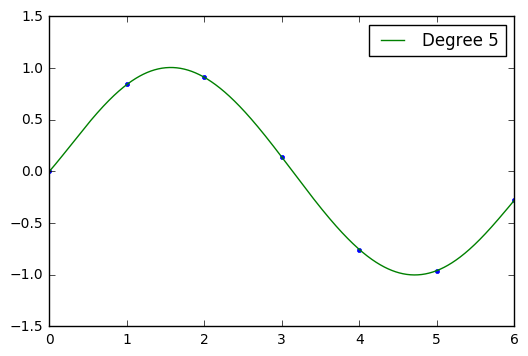

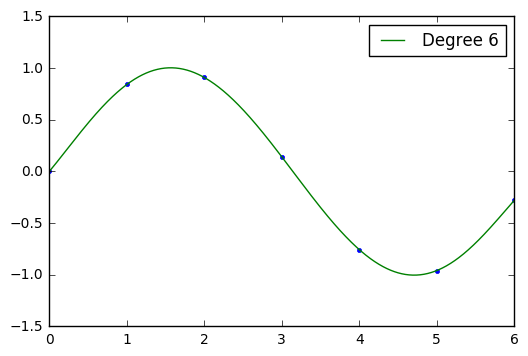

C:\Users\Yordan\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


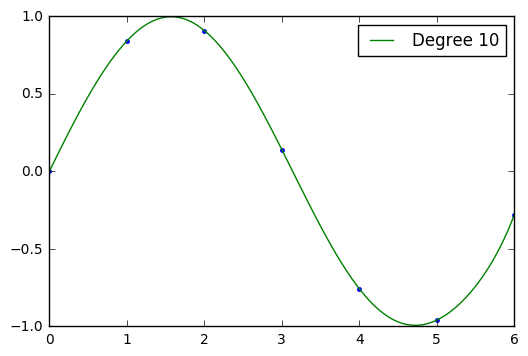

C:\Users\Yordan\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


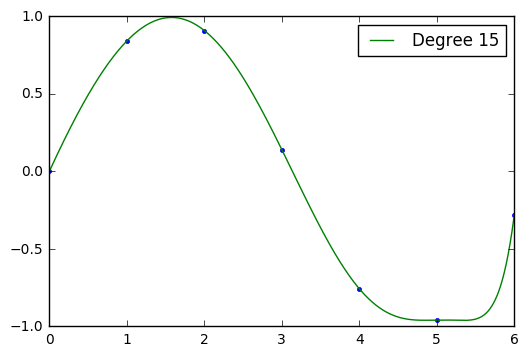

C:\Users\Yordan\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\Yordan\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


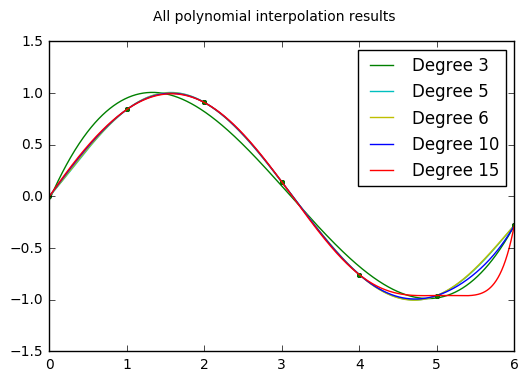

C:\Users\Yordan\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\Yordan\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


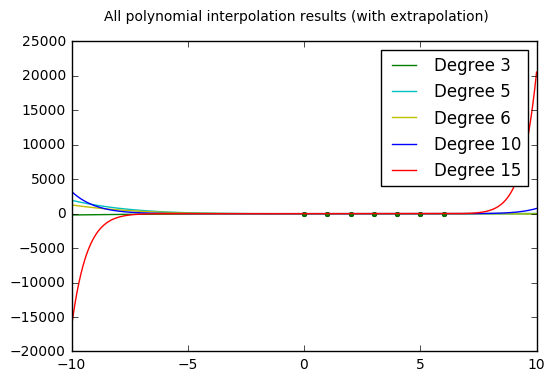

In [10]:
x = np.array(np.arange(0, 7))
y = np.array([0, 0.8415, 0.9093, 0.1411, -0.7568, -0.9589, -0.2794])
x_hat = np.linspace(0, 6, 1000)
x_hat_extended = np.linspace(-10, 10, 1000)

for degree in [3, 5, 6, 10, 15]:
    fit = np.poly1d(np.polyfit(x, y, degree))
    plt.plot(x, y, '.')
    plt.plot(x_hat, fit(x_hat), label = "Degree " + str(degree))
    plt.legend()
    plt.show()
    
plt.suptitle("All polynomial interpolation results")
for degree in [3, 5, 6, 10, 15]:    
    fit = np.poly1d(np.polyfit(x, y, degree))
    plt.plot(x, y, '.')
    plt.plot(x_hat, fit(x_hat), label = "Degree " + str(degree))
    plt.legend()
plt.show()

plt.suptitle("All polynomial interpolation results (with extrapolation)")
for degree in [3, 5, 6, 10, 15]:
    fit = np.poly1d(np.polyfit(x, y, degree))
    plt.plot(x, y, '.')
    plt.plot(x_hat_extended, fit(x_hat_extended), label = "Degree " + str(degree))
    plt.legend()
plt.show()

### 7. Finding Equation Roots
We're going to use Newton - Raphson's method to find some roots of these equations:
$$
x^3 - 2x - 5 = 0,\ x_0 = 2 \\
e^{2x} = x + 6 \\
\tan(x) = 4x
$$

For the second equation we have to find all roots, and for the third - the first two non-negative roots. Note that we can see where we can start searching by plotting the functions first. Also note that we have to be sufficiently close to the root when we select the initial value, $x_0$. If we aren't, the algorithm is not going to converge (e.g. not going to find the root).

In [11]:
def f1(x):
    return x**3 - 2 * x - 5

def df1(x):
    return 3 * x**2 - 2

def f2(x):
    return np.exp(2 * x) - x - 6

def df2(x):
    return 2 * np.exp(2 * x) - 1
    
def f3(x):
    return np.tan(x) - 4 * x

def df3(x):
    return 1 / np.cos(x) ** 2 - 4

root = scipy.optimize.newton(f1, 2.2, df1)
print("Root of x^3 - 2x - 5 = 0 near 2: x = " + str(round(root, 4)))
print()

for x0 in [-6.2, 1]:
    root = scipy.optimize.newton(f2, x0, df2)
    print("Root of e^(2x) = x + 6 near " + str(x0) + ": x = " + str(round(root, 4)))
print()

for x0 in [0, 1.5]:
    root = scipy.optimize.newton(f3, x0, df3)
    print("Root of tan(x) = 4 * x near " + str(x0) + ": x = " + str(round(root, 4)))

Root of x^3 - 2x - 5 = 0 near 2: x = 2.0946

Root of e^(2x) = x + 6 near -6.2: x = -6.0
Root of e^(2x) = x + 6 near 1: x = 0.9709

Root of tan(x) = 4 * x near 0: x = 0.0
Root of tan(x) = 4 * x near 1.5: x = 1.3932


### 8. Square Root
A very simple application of Newton - Raphson's method is finding square roots. Let's derive the solution.

The square root $x$ of a number $a$ is the solution to the equation $x^2 = a$. We have to write this as a function in the form $x^2 - a = 0$.

We take an initial guess $x_0$. We improve it each time using the Newton - Raphson formula:
$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$

We substitute with $f(x_n) = x_n^2 - a$ and $f'(x_n) = 2x_n$ to get
$$ x_{n+1} = x_n - \frac{x_n^2 - a}{2x_n} = \frac{2x_n^2 - x_n^2 + a}{2x_n} = \frac{x_n^2 + a}{2x_n} = \frac{1}{2}\left(x_n+\frac{a}{x_n}\right) $$

We can prove that this always converges but that's outside the scope of this lecture. Let's see this in an example:

In [12]:
def calculate_sqrt(x, guess = 1, precision = 1e-12):
    while not (abs(guess * guess - x) < precision):
        guess = (guess + (x / guess)) / 2.0
    return guess

print(calculate_sqrt(25))
print(calculate_sqrt(8))

5.0
2.82842712474619


### 9. Fourier Transform of Generated Waves
We're going to explore the Fourier transform and plot the power spectrum of several well-known functions in signal processing: a sine wave and a cosine wave with unit amplitudes and frequencies. We're also going to extend this to other dunctions: sawtooth signal, rectangular pulse signal, sinc ($\sin(x)/x$) and Gaussian signal.

Note that the transformation is symmetric with respect to y = 0. This is always the case when we have real-valued signals. It means that we need half of the spectrum (with frequencies >= 0). The other half doesn't carry any information. However, in this lab, we're going to plot the entire transform results just to get a feel of what a spectrum looks like.

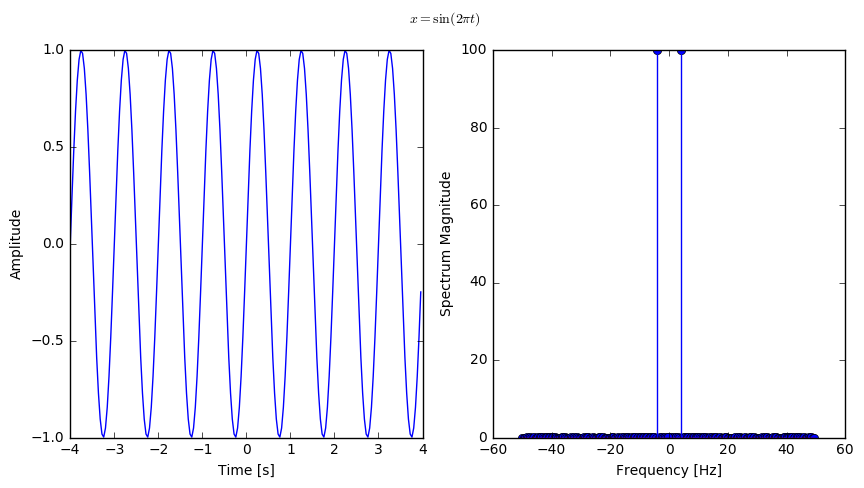

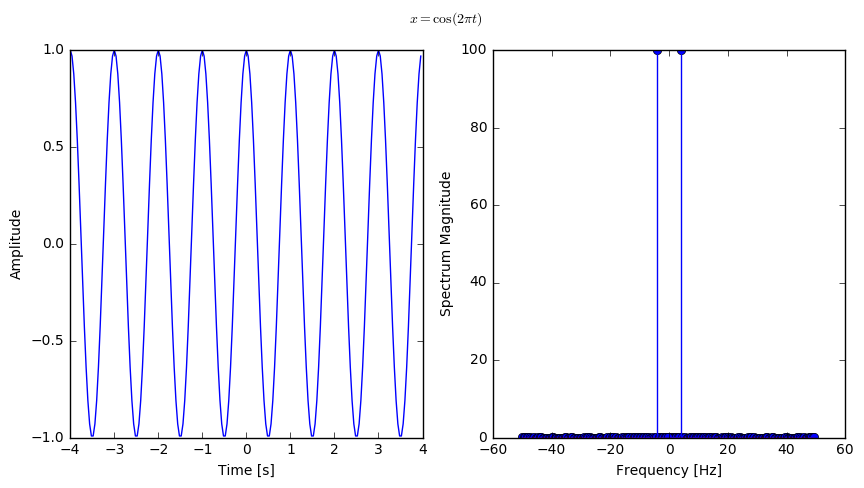

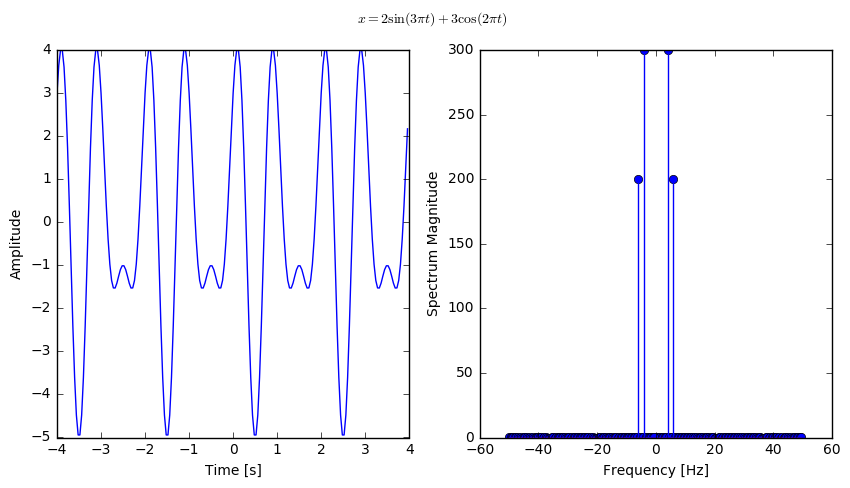

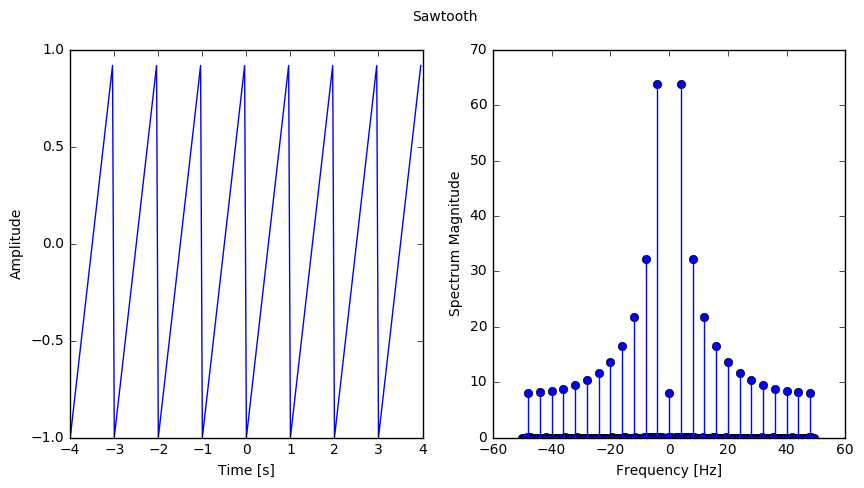

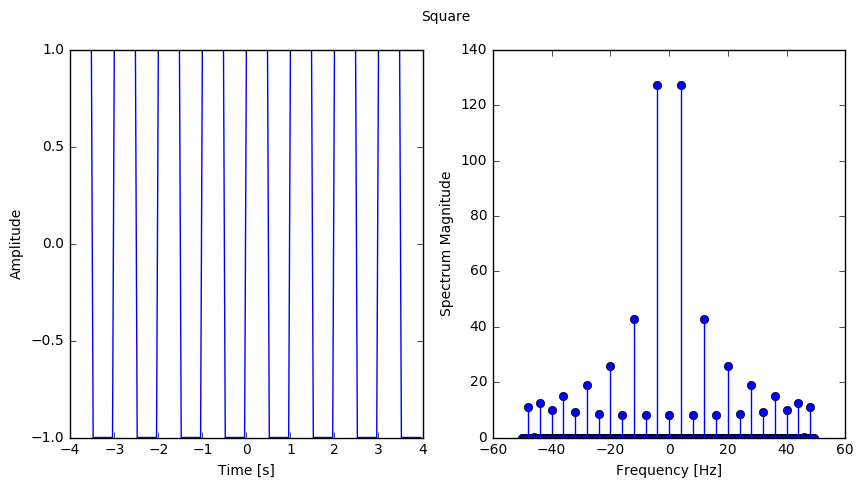

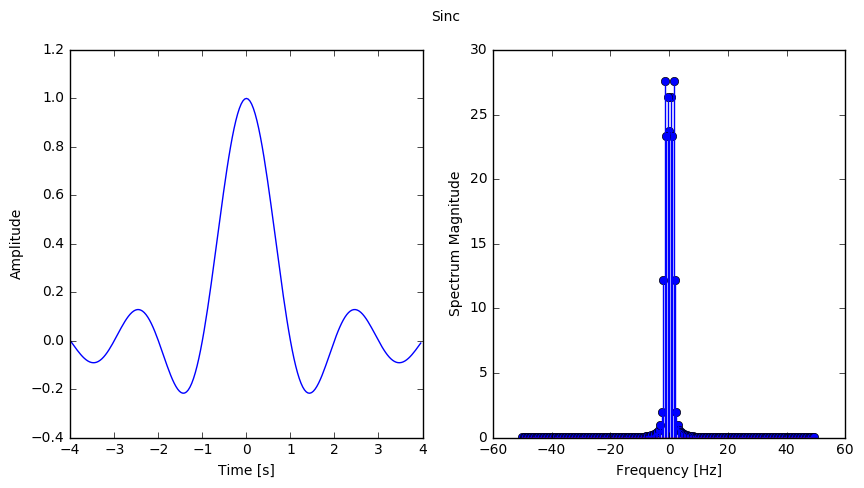

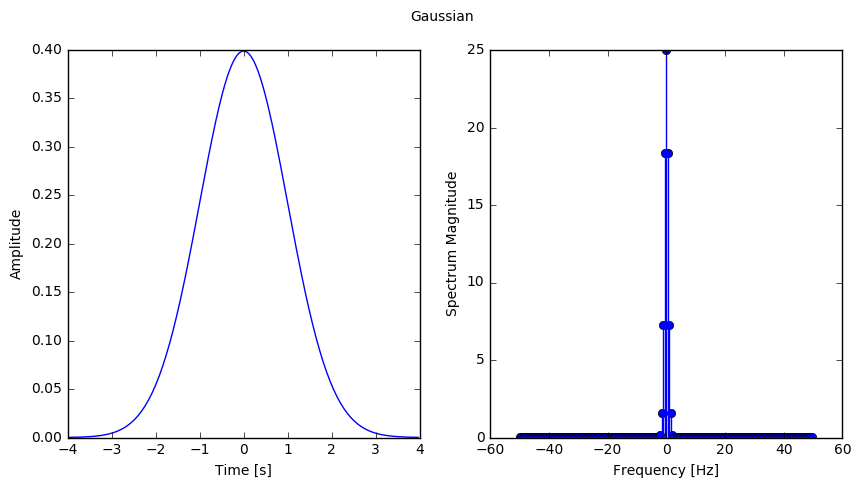

In [13]:
f_s = 100 # Sampling rate
t = np.linspace(-4, 4, 2 * f_s, endpoint = False)
functions = [
    (np.sin(2 * np.pi * t), "$x = \sin(2\pi t)$"),
    (np.cos(2 * np.pi * t), "$x = \cos(2\pi t)$"),
    (2 * np.sin(3 * np.pi * t) + 3 * np.cos(2 * np.pi * t), "$x = 2\sin(3\pi t) + 3\cos(2\pi t)$"),
    (scipy.signal.sawtooth(2 * np.pi * t), "Sawtooth"),
    (scipy.signal.square(2 * np.pi * t), "Square"),
    (np.sinc(t), "Sinc"),
    (scipy.stats.norm.pdf(t), "Gaussian")
]

for f, title in functions:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    plt.suptitle(title)
    ax1.plot(t, f)
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Amplitude")

    F = fftpack.fft(f)
    freqs = fftpack.fftfreq(len(f)) * f_s
    ax2.stem(freqs, np.abs(F))
    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Spectrum Magnitude")
    plt.show()

### 10. Fourier Transform of Sound
Now that we're familiar with Fourier transforms and signal spectra, let's plot the Fourier transform of an audio signal.

First, we'll read a **.wav** file from the file system. We'll select only one channel (it has two channels but we don't need both to create the spectrum, so we'll use the left one). After that we'll plot the original signal (in time domain), and the Fourier spectrum. Since the spectrum is highly skewed, engineers prefer to use different units. In our case we'll plot the frequency in kHz and the intensity (amplitude) in dB which is a log-transformation and will allow us to see some components more easily.

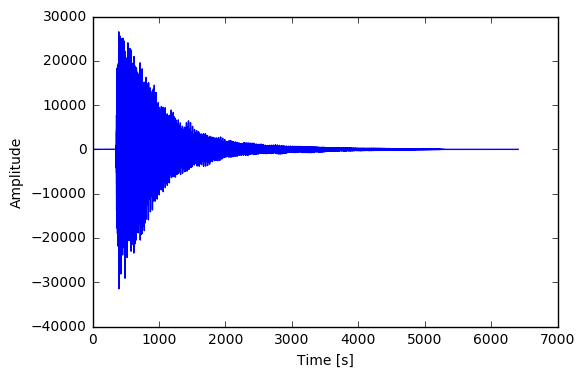

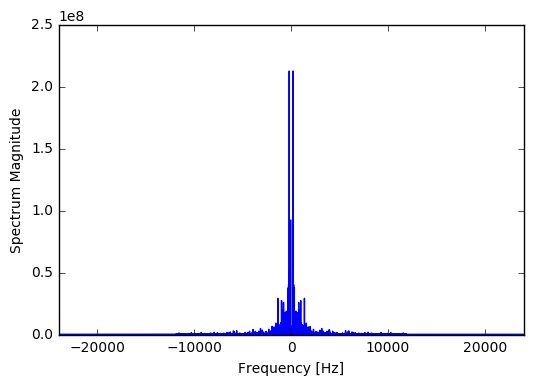

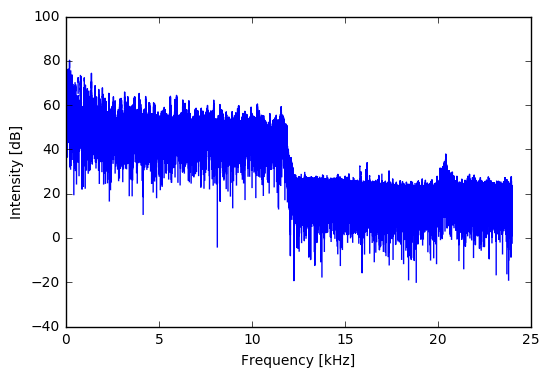

In [14]:
bitrate, data = scipy.io.wavfile.read("c-chord.wav")
time_signal = data.T[0] # Left channel
time = np.arange(0, len(time_signal), 1) / bitrate * 1000 # Milliseconds
fig, ax = plt.subplots()
ax.plot(time, time_signal)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
plt.show()

transformed_signal = fftpack.fft(time_signal)
freqs = fftpack.fftfreq(len(time_signal)) * bitrate
fig, ax = plt.subplots()
ax.plot(freqs, np.abs(transformed_signal))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Spectrum Magnitude")
ax.set_xlim(-bitrate / 2, bitrate / 2)
plt.show()

fig, ax = plt.subplots()
unique_points = int(math.ceil((len(time_signal) + 1) / 2.0))
freq_array = np.arange(0, unique_points, 1.0) * (bitrate / len(data))

ax.plot(freq_array / 1000, 10 * np.log10(np.real(transformed_signal))[0:unique_points])
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Intensity [dB]")
plt.show()